# ADS Thesis Project - SVM Model Goat

**Authors: Marion Späth (2772981)**


This notebook documents the Boosting Models for both goat and goat herders.
The datasets have been created in the R file for the Elastic Net.

In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import os
import pickle
import shap

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
test_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,4,4,No,35,Yes,No,Never attended,1,No,0,0,-53.165897,0.0,3,Elementary,7,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.488589,-0.191439,-0.140337,0.922786,-0.474056,3.992052,-0.781516
1,12,4,No,30,No,No,Never attended,1,No,0,0,-115.108932,0.0,3,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,3,Interpersonal Sources,Christian,0,Yes,Lack of Awareness or Understanding,No,No,-0.786820,0.582578,-0.140337,-0.899432,-0.474056,4.754529,-0.050775


In [3]:
# Prepare categorical variables but creating dummies
train_goat = pd.get_dummies(train_goat, drop_first='True')
test_goat = pd.get_dummies(test_goat, drop_first='True')

# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]

In [4]:
%%time
# Align columns in test set
#X_goat_TEST_encoded = X_goat_TEST_encoded.reindex(columns=X_goat_encoded.columns, fill_value=0)

# Define SVM model
svr = SVR()

# Define parameter grid for randomized search
param_grid = {
    'C': np.logspace(-2, 2, 20),            # regularization strength
    'epsilon': np.linspace(0.01, 1.0, 20),  # tolerance for error
    'kernel': ['rbf', 'linear'],            # two common kernels for regression
    'gamma': ['scale', 'auto']             # kernel coefficient
}

# Define custom scorer for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform randomized search
svr = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=100,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

svr.fit(X_goat, Y_goat)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
CPU times: total: 5.47 s
Wall time: 4min 59s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8...
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'linear']},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [5]:
# Pickle the model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'svr_m1_goatv1.pickle', 'wb') as to_write:
    pickle.dump(svr, to_write)

In [6]:
# Read in pickled model (refit on mae)
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'svr_m1_goatv1.pickle', 'rb') as to_read:
    svrm1v1 = pickle.load(to_read)

print("Best hyperparameters:\n", svrm1v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification:\n", svrm1v1.best_score_)

Best hyperparameters:
 {'kernel': 'linear', 'gamma': 'auto', 'epsilon': 0.9478947368421053, 'C': 0.016237767391887217} 

Performance based on best hyperparameter specification:
 -1.9108758882235353


In [8]:
# 3. Predict on the test set
y_predm1v1 = svrm1v1.predict(X_goat_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_goat_TEST, y_predm1v1)
mse = mean_squared_error(Y_goat_TEST, y_predm1v1)
r2  = r2_score(Y_goat_TEST, y_predm1v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0305
Root Mean Squared Error (RMSE):  1.3697
R-squared (R²):            0.0101


# Refit using Education Variables as Numeric Variables

Goal: By (slightly) reducing the number of categorical variables, and increasing the number of numeric variables, the R2 might be increased. 

In [9]:
# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]
# Prepare categorical variables but creating dummies
X_goat = pd.get_dummies(X_goat, drop_first='True')
X_goat_TEST = pd.get_dummies(X_goat_TEST, drop_first='True')
X_goat_TEST.columns

Index(['expend', 'irrigated_land_bin', 'owns_phone', 'age_constant_z',
       'number_adults_z', 'number_minors_z', 'educ_child_z', 'educ_adult_z',
       'afm_language_Yes', 'agric_land_Yes', 'amh_language_Yes',
       'eng_language_Yes', 'activity_child_recoded_Not working',
       'activity_child_recoded_Student', 'activity_child_recoded_Working',
       'activity_child_recoded_Working with Livestock',
       'household_description_Not settled: The whole household moves around in order to herd the animals',
       'household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals',
       'main_info_source_recoded_Media, Community-Based, and Survey Sources',
       'main_info_source_recoded_Professional and Organizational Sources',
       'religion_recoded_Muslim', 'religion_recoded_Traditional/Wakefata',
       'household_moved_Yes',
       'why_not_purchase_recoded_Distrust or Negative Perception',


In [10]:
%%time
# Align columns in test set
#X_goat_TEST_encoded = X_goat_TEST_encoded.reindex(columns=X_goat_encoded.columns, fill_value=0)

# Define SVM model
svr = SVR()

# Define parameter grid for randomized search
param_grid = {
    'C': np.logspace(-2, 2, 20),            # regularization strength
    'epsilon': np.linspace(0.01, 1.0, 20),  # tolerance for error
    'kernel': ['rbf', 'linear'],            # two common kernels for regression
    'gamma': ['scale', 'auto']             # kernel coefficient
}

# Define custom scorer for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform randomized search
svr = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=100,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

svr.fit(X_goat, Y_goat)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
CPU times: total: 4.88 s
Wall time: 4min 31s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8...
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'linear']},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [11]:
# Pickle the model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'svr_m2_goatv1.pickle', 'wb') as to_write:
    pickle.dump(svr, to_write)

In [12]:
# Read in pickled model (refit on r2)
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'svr_m2_goatv1.pickle', 'rb') as to_read:
    svrm2v1 = pickle.load(to_read)

print("Best hyperparameters:\n", svrm2v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification:\n", svrm2v1.best_score_)

Best hyperparameters:
 {'kernel': 'linear', 'gamma': 'auto', 'epsilon': 1.0, 'C': 0.18329807108324356} 

Performance based on best hyperparameter specification:
 -1.9089374892692326


In [13]:
# 3. Predict on the test set
y_predm2v1 = svrm2v1.predict(X_goat_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_goat_TEST, y_predm2v1)
mse = mean_squared_error(Y_goat_TEST, y_predm2v1)
r2  = r2_score(Y_goat_TEST, y_predm2v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0266
Root Mean Squared Error (RMSE):  1.3679
R-squared (R²):            0.0127


In [14]:
# 1. Best model
best_model = svrm2v1.best_estimator_
best_model

SVR(C=0.18329807108324356, epsilon=1.0, gamma='auto', kernel='linear')

In [19]:
# 2. Explainer
X_sample = X_goat.sample(n=100, random_state=0)
explainer = shap.KernelExplainer(best_model.predict, X_sample)

In [20]:
# 3. Sample data (if large)
X_sample = X_goat.sample(n=100, random_state=0)
#shap_interaction_values = explainer.shap_interaction_values(X_goat)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


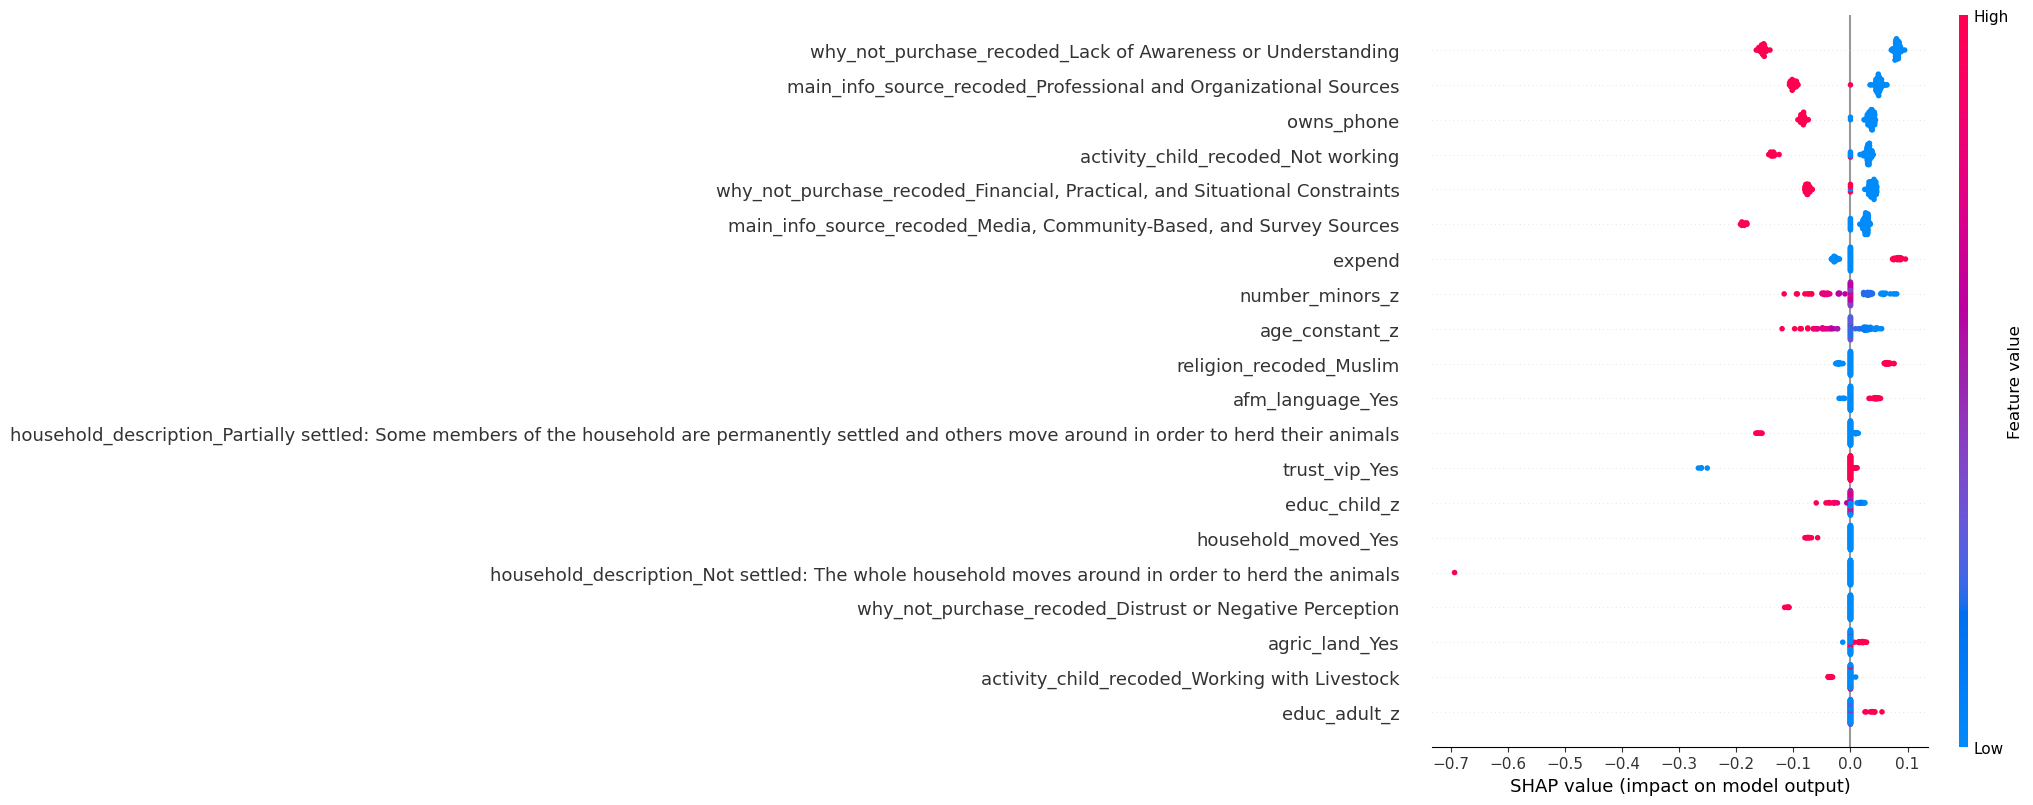

In [21]:
# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="dot",
)